<a href="https://colab.research.google.com/github/viniciuslbo/Investimento/blob/main/ML_Investing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import 


In [1]:
import tensorflow.compat.v1 as tf #Machine Learning
!pip install yfinance --upgrade --no-cache-dir #Install yfinance
import yfinance as yf #Import yahoo finance
yf.pdr_override()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
#tf.disable_v2_behavior()
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import requests
import random
!pip install bt
import bt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16,8)
matplotlib.rcParams.update({'font.size': 22})

     |████████████████████████████████| 6.3 MB 19.4 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=344a2950755d4678e12558f1c838e9ea6f34fde4257052d6875abf8a188d4d03
  Stored in directory: /tmp/pip-ephem-wheel-cache-vq33woup/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 2.7 MB 11.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bt: filename=bt-0.2.9-cp37-cp37m-linux_x86_64.whl size=765323 sha256=0fd99ecc63230b0a63ef9605315ef7bace68dd400323180ab2db1dc76660ec20
  Stored in directory: /root/.cache/pip/wheels/c5/1a/3f/b56e6064b766c107f25e200969161c09ca6868cbfe0eaa31e4
Successfully built bt


#Base de Dados (Código Definitivo)

In [2]:
def get_stock_data(stocks, start_date, end_date):
  #####
  ####
  #Ideias futuras: Colocar como entrada uma lista de ações
  #
  ####
  ####
  #Function to get data stocks
  #date format: yy-m-d (string)
  #############################
  ###### Importação ###########
  #############################
  stocks_list = list(np.zeros((len(stocks))))
  for i in range(len(stocks)):
    stocks_list[i] = str(stocks[i]) + '.SA'

  data_ = web.get_data_yahoo(stocks_list, start = start_date, end=end_date)['Adj Close']
  data = web.get_data_yahoo(stocks_list, start = start_date, end=end_date)['Adj Close']
  ##################################
  ####### Tratamento de Dados#######
  ##################################
  ############
  #Dados = 0 #
  ############

  for i in range(len(data.columns)):
    data_zero = data.loc[data[data.columns[i]] == 0]
    if len(data_zero) != 0:
      data.drop(data_zero.index, inplace = True)

  ###########
  #Dados < 0#
  ###########

  for i in range(len(data.columns)):
    data_zero = data.loc[data[data.columns[i]] < 0]
    if len(data_zero) != 0:
      data.drop(data_zero.index, inplace = True)

  #################
  #Dados Faltantes#
  #################
  data.dropna()
  #################
  # Escalonamento #
  #################
  #scaler = MinMaxScaler()
  #data = scaler.fit_transform(data)

  data = pd.DataFrame(data, columns= data_.columns)
  data = data.rename(columns = {'Adj Close': 'Adj_Close'})

  ###############################
  #### Up [1 0] or Down [0 1] ###
  ###############################
  '''
  price_diff = []
  for i in range(len(data.Open)-1):
    if data.Open[i + 1] >= data.Adj_Close[i]:
      price_diff.append([1, 0])
    else:
      price_diff.append([0, 1])
  price_diff[0] = [1, 0]
  '''
  ###### Add new Column ########
  return data



########################
#Dados Fundamentalistas#
########################
def Dados_Fundamentalistas():
  url = 'http://www.fundamentus.com.br/resultado.php'
  
  header = {
  "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36"  }
  r = requests.get(url, headers=header)

  dados = pd.read_html(r.text,  decimal=',', thousands='.')[0]
  
  #No Fundamentos o decimal é dado por ',' e milhares em '.', e porcentagem esta em 'string', para concertar isso temos
  for coluna in ['Div.Yield', 'Mrg Ebit', 'Mrg. Líq.', 'ROIC', 'ROE', 'Cresc. Rec.5a']:
    dados[coluna] = dados[coluna].str.replace('.', '')
    dados[coluna] = dados[coluna].str.replace(',', '.')
    dados[coluna] = dados[coluna].str.rstrip('%').astype('float') / 100


  #Evitando empresas muito pequenas.
  #Empresas muito pequenas tendem a ter dados faltantes no Fundamentos
  dados = dados[dados['Liq.2meses'] > 1000000]

  #################
  #Pegando Setores#
  #################
  # O último comando retirou muitas ações
  # portanto nem todos os indices estão disponiveis.
  # precisamos resetar os indices
  dados = dados.reset_index(drop = True)
  
  Lista_de_setores = []

  for i in range(len(dados.index)):
    url_setor = 'http://www.fundamentus.com.br/detalhes.php?papel=' + '%s' %dados.Papel[i]
    r = requests.get(url_setor, headers=header)
    Dados_Setor = pd.read_html(r.text,  decimal=',', thousands='.')[0]
    Lista_de_setores.append(Dados_Setor[1][3])

  #Criando nova coluna
  dados['Setor'] = Lista_de_setores

  return dados



def Carteira(period_= '1y'):
  nome_acoes = Dados_Fundamentalistas().Papel

  tickers_ = []
  for i in range(len(nome_acoes)):
    tickers_.append('%s' %nome_acoes[i] + '.SA')

  dados_ = yf.download(tickers=tickers_, period= period_)["Adj Close"]

  #Excluir colunas que estejam sem dados
  dados_.dropna(how='all', inplace=True)

  #Excluir colunas que tenham mais de um dado faltante
  dados_.dropna(axis=1, inplace=True, thresh=len(dados_.index) - 1)


  return dados_


def Random_Carteira(period_ = '1y'):
  #Cria tabela retorno, com a varição em porcentagem de cada ativo
  retorno = Carteira().pct_change()
  
  #Retorno Acumulado
  retorno_acumulado = (1 + retorno).cumprod()
  retorno_acumulado.iloc[0] = 1

  carteira_random_acoes = []
  for i in range(500):
    carteira_random = random.sample(list(retorno.columns) , k=5)
    carteira_random_acoes.append(carteira_random)
    carteira_random = 10000 * retorno_acumulado.loc[: , carteira_random]
    carteira_random['saldo'] = carteira_random.sum(axis=1)
    carteira_random['saldo'].plot(figsize=(18,8))
    #print(carteira_random['saldo'][len(carteira_random)]/carteira_random['saldo'][0])


  #Download dados do BOVA11
  ibov = yf.download('BOVA11.SA', period= period_)["Adj Close"]
  #Normalizando BOVA11
  ibov = ibov / ibov.iloc[0]

  (ibov*50000).plot(linewidth=4, color='black')
  '''
  buy_hold = bt.Strategy('Buy&Hold', 
                   [ bt.algos.RunOnce(),
                     bt.algos.SelectAll(),
                     bt.algos.WeighEqually(),
                     bt.algos.Rebalance()]
                    )

  #Backtesting
  for j in range(len(carteira_random_acoes)):
    print(carteira_random_acoes[j])
    dados_ = yf.download(tickers=carteira_random_acoes[j], period= period_)["Adj Close"]
    bt1 = bt.Backtest(buy_hold, dados_)
    resultados = bt.run(bt1)
    resultados.display()
   '''
  return retorno_acumulado





###########################################
### Criando Base de Teste e Treinamento ###
###########################################
def train_test(data):
  data_treinamento, data_test = train_test_split(data, test_size = 0.25, random_state = 0)
  return data_treinamento, data_test



##########################################
############## SOURCE ####################
##########################################

def main(stocks, start_date, final_date):
  data = get_stock_data(stocks, start_date, final_date)


  return
  

In [3]:
web.get_data_yahoo('ITSA4.SA', start = "2005-05-25", end="2008-05-25")

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-05-25,2.684681,2.706508,2.635571,2.651941,1.459940,4709703
2005-05-27,2.728335,2.733791,2.662855,2.679225,1.474960,2640804
2005-05-30,2.662855,2.711965,2.646485,2.673768,1.471956,2528923
2005-05-31,2.651941,2.701051,2.651941,2.684681,1.477964,6544155
2005-06-01,2.701051,2.750161,2.684681,2.728335,1.501996,10821453
...,...,...,...,...,...,...
2008-05-16,5.518423,5.533337,5.409048,5.423963,2.990046,23598665
2008-05-19,5.463736,5.518423,5.423963,5.458764,3.009230,24533182
2008-05-20,5.404077,5.404077,5.309617,5.354361,2.951677,22259445


In [8]:
stocks = [ 'BIDI4','CVCB3','ENBR3','ITSA4','MYPK3','ODPV3' , 'RAPT4'] 
data_inicio = '2020-01-01'
data_fim    = '2020-9-1'
weight = [0.1647,0.0634,0.0436,0.1412, 0.1065, 0.0158, 0.1180]
A = get_stock_data(stocks, data_inicio, data_fim)

def Backtesting(stocks,data_inicio,data_fim,weight):
  ####Precisamos redefinir a string se não o bt não reconhece para o backtesting
  ####por exemplo, precisamos mudar: ITSA4 por ITSA
  ####
  stocks_redefine = list(np.zeros((len(stocks))))
  for i in range(len(stocks_redefine)):
    stocks_redefine[i] = stocks[i][0] + stocks[i][1] + stocks[i][2] + stocks[i][3]
  #
  # Criando uma carteira
  #
  carteira = get_stock_data(stocks, data_inicio, data_fim)
  for i in range(len(carteira.columns)):
    carteira = carteira.rename(columns = {carteira.columns[i]: carteira.columns[i][0] + carteira.columns[i][1] + carteira.columns[i][2] + carteira.columns[i][3]})

  #
  # Criando um backtesting
  #
  
  #Especificando pesos
  weights = pd.Series(weight,index = carteira.columns)
  weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)
  ###
  #Estrategia Buy & Hold
  buy_hold = bt.Strategy('Buy&Hold', 
                   [ bt.algos.RunOnce(),
                     bt.algos.SelectAll(),
                     weighSpecifiedAlgo,
                     bt.algos.Rebalance()
                     ]
                    )
  bt2 = bt.Backtest(buy_hold, carteira)
  resultado = bt.run(bt2)
  resultado.plot()
  plt.title('Carteira')
  return resultado.display()

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed


[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
Stat                 Buy&Hold
-------------------  ----------
Start                2020-01-01
End                  2020-08-31
Risk-free rate       0.00%

Total Return         -10.26%
Daily Sharpe         -0.32
Daily Sortino        -0.44
CAGR                 -15.02%
Max Drawdown         -36.90%
Calmar Ratio         -0.41

MTD                  -1.20%
3m                   17.68%
6m                   -0.48%
YTD                  -10.26%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  -15.02%

Daily Sharpe         -0.32
Daily Sortino        -0.44
Daily Mean (ann.)    -10.68%
Daily Vol (ann.)     33.72%
Daily Skew           -1.11
Daily Kurt           5.09
Best Day             7.43%
Worst Day            -9.17%

Monthly Sharpe       -0.13
Monthly Sortino      -0.18
Monthly Mean (ann.)  -5.12%
Mo

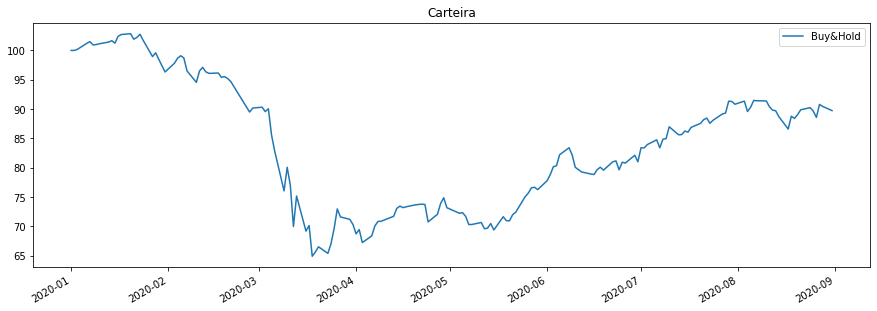

In [9]:
Backtesting(stocks, data_inicio, data_fim,weight)

# Analise Técnica 

In [10]:
!pip install pyqstrat

     |████████████████████████████████| 3.4 MB 11.5 MB/s 
     |████████████████████████████████| 9.8 MB 66.5 MB/s 
     |████████████████████████████████| 788 kB 84.5 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
     |████████████████████████████████| 23.9 MB 1.3 MB/s 
     |████████████████████████████████| 374 kB 54.6 MB/s 
  ERROR: Failed building wheel for pyqstrat
  Running setup.py clean for pyqstrat
Failed to build pyqstrat
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: p

#Functions (Rascunho)


In [ ]:

def get_stock_data(stock_symbol, start_date, end_date):
  #Function to get data stocks
  #date format: yy-m-d (string)
  data = web.get_data_yahoo(stock_symbol + '.SA', start = start_date, end=end_date)
  return pd.DataFrame(data)


def calculate_price_diff(opens,closes):
  # Return: [1 0] if price up or [0 1] if price down
  price_diff = []
  for i in range(len(opens)-1):
    if opens[i + 1] >= closes[i]:
      price_diff.append([1, 0])
    else:
      price_diff.append([0, 1])
  return price_diff


def create_datasets(stock_symbol, start_date, end_date):
  #Create a data set with all data, and up(down) prediction
  data = web.get_data_yahoo(stock_symbol + '.SA', start = start_date, end=end_date )
  Date = data.index
  Close = data.Close
  Adj_Close = data['Adj Close']
  Low = data.Low
  High = data.High
  Open = data.Open
  Volume = data.Volume/1000

  labels = calculate_price_diff(Open,Close)

  inputs = []

  for i in range(len(labels)):
    inputs.append([Close[i], Adj_Close[i], Low[i], High[i], Open[i], Volume[i]])

  return inputs, labels


In [ ]:
def measure_accuracy(actual, expected):
  num_correct = 0 
  for i in range(len(actual)):
    actual_value = actual[i]
    expected_value = expected[i]
    if actual_value[0] >= actual_value[1] and expected_value[0] >= expected_value[1]:
      num_correct += 1
    elif actual_value[0] <= actual_value[1] and expected_value[0] <= expected_value[1]:
      num_correct += 1
  return (num_correct/len(actual)) * 100


#Keras (RNN) (Rascunho de ML)


[*********************100%***********************]  1 of 1 completed


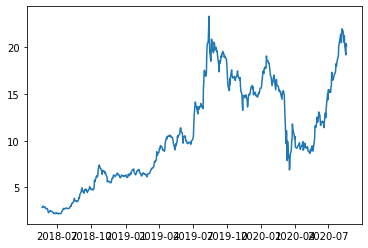

In [ ]:
data = get_stock_data('BIDI4', '2018-05-20', '2020-08-20')['Adj Close']
plt.plot(data.index,data)
#data = [data.index,data[0,:]]

In [ ]:
data = pd.DataFrame(data)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#Normalize Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
#print(scaled_data)

In [ ]:
train_length = int(len(scaled_data) * 0.7) #70% to training
test_length  = int(len(scaled_data) * 0.3) #30% to test
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

In [ ]:
def create_dataset(dataset, timestep = 1):
  data_x, data_y = [], []
  for i in range(len(dataset) - timestep - 1):
    data_x.append(dataset[i:(i+timestep), 0])
    data_y.append(dataset[i+timestep, 0])
  return np.array(data_x), np.array(data_y)



In [ ]:
timestep = 1
train_x, train_y =  create_dataset(train_data, timestep)
test_x, test_y =  create_dataset(test_data, timestep)

In [ ]:
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [ ]:
model = Sequential()
model.add(LSTM(300, input_shape=(1,1)))
model.add(Dense(10, activation= 'sigmoid'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 300)               362400    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                3010      
Total params: 365,410
Trainable params: 365,410
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(train_x,train_y,epochs=1, batch_size=1, verbose=1)
score = model.evaluate(train_x,train_y, verbose=0)
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

387/387 [==============================] - 1s 2ms/step - loss: 0.0441 - accuracy: 0.0000e+00
Keras model loss =  0.005437170621007681
Keras model accuracy =  0.0


In [ ]:
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)
print(len(train_predictions))

387


In [ ]:
train_predictions = scaler.inverse_transform(train_predictions)
train_y = scaler.inverse_transform([train_y])

test_predictions = scaler.inverse_transform(test_predictions)
test_y = scaler.inverse_transform([test_y])

print(train_predictions)

[[ 5.420645   5.520798   5.487359  ...  5.448936   5.40824    5.4490356]
 [ 5.4475803  5.547352   5.5140815 ...  5.4756856  5.435143   5.4758368]
 [ 5.4794807  5.5787854  5.545722  ...  5.507357   5.467006   5.5075746]
 ...
 [14.95609   14.6862955 14.800989  ... 14.820372  14.948308  14.848684 ]
 [14.626362  14.368435  14.4783745 ... 14.495768  14.618157  14.523373 ]
 [14.826329  14.561131  14.673983  ... 14.692592  14.818379  14.720633 ]]


In [ ]:
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:,:] = np.nan
train_predict_plot[1:len(train_predictions)+1,:]= train_predictions[:,8].reshape((387,1))

In [ ]:
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predictions)+2+1:len(scaled_data)-1,:]= test_predictions[:,8].reshape((165,1))

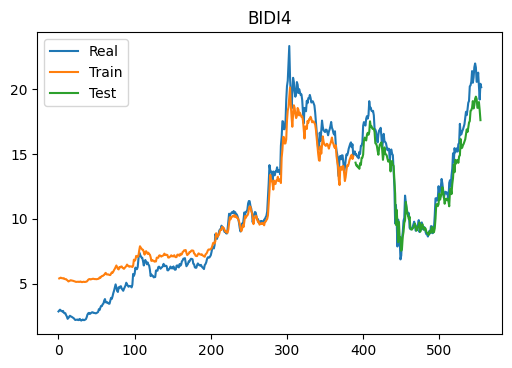

In [ ]:
plt.figure(dpi=100)
plt.plot(scaler.inverse_transform(scaled_data), label = 'Real')
plt.plot(train_predict_plot, label = 'Train')
plt.plot(test_predict_plot, label = 'Test')
plt.title(label = 'BIDI4')
plt.legend()
plt.show()